In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
file_path = 'train.csv'  
df = pd.read_csv(file_path)
df.columns

Index(['Unnamed: 0', 'id', 'stmt_date', 'HQ_city', 'legal_struct',
       'ateco_sector', 'def_date', 'fs_year', 'asst_intang_fixed',
       'asst_tang_fixed', 'asst_fixed_fin', 'asst_current', 'AR',
       'cash_and_equiv', 'asst_tot', 'eqty_tot', 'eqty_corp_family_tot',
       'liab_lt', 'liab_lt_emp', 'debt_bank_st', 'debt_bank_lt', 'debt_fin_st',
       'debt_fin_lt', 'AP_st', 'AP_lt', 'debt_st', 'debt_lt', 'rev_operating',
       'COGS', 'prof_operations', 'goodwill', 'inc_financing', 'exp_financing',
       'prof_financing', 'inc_extraord', 'taxes', 'profit', 'days_rec',
       'ebitda', 'roa', 'roe', 'wc_net', 'margin_fin', 'cf_operations'],
      dtype='object')

# Make Hypothetical Train and Test CSVs

In [3]:
test_df = df[df['fs_year'] == 2012]
train_df = df[df['fs_year'] != 2012]

test_df.to_csv('test_for_2012.csv', index=False)
train_df.to_csv('train_for_2012.csv', index=False)

# Helper FUNCTIONS
-----
- calculate_default_within_year
- create growth features
- make_quantiles

In [4]:
def calculate_default_within_year(df, stmt_date_col='stmt_date', def_date_col='def_date', days_until_statement=150):
    """
    Calculate a default status within an adjusted timeframe and create a column indicating this in the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing statement and default dates.
    - stmt_date_col (str): Column name for the statement date.
    - def_date_col (str): Column name for the default date.
    - days_until_statement (int): Number of days to add to the statement date before calculating the one-year window. Default is 150.
    
    Returns:
    - float: The mean of the 'default_within_timeframe' column, representing the proportion of defaults within the adjusted one-year period.
    """
    # Convert columns to datetime
    df[stmt_date_col] = pd.to_datetime(df[stmt_date_col])
    df[def_date_col] = pd.to_datetime(df[def_date_col])
    
    # Adjust the statement date by adding days_until_statement
    adjusted_stmt_date = df[stmt_date_col] + pd.DateOffset(days=days_until_statement)
    
    # Calculate one year after the adjusted statement date
    one_year_after = adjusted_stmt_date + pd.DateOffset(years=1)
    
    # Define default status within the adjusted one-year period and create the column
    df['default'] = ((df[def_date_col] >= adjusted_stmt_date) & (df[def_date_col] <= one_year_after)).astype(int)
    
    # Return the mean of the default_within_timeframe column
    return df

def make_quantiles(df, field, num_quantiles=4, custom_bins = {}, new_column_name=None, new=True, preproc_params = None):
    """
    Creates a new column in the DataFrame indicating the quantile for each row based on a specified field.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - field (str): The column name of the field to compute quantiles for.
    - num_quantiles (int): The number of quantiles to divide the field into (default is 4 for quartiles).
    - new_column_name (str): The name for the new column to store the quantile information.
                             If None, defaults to '{field}_quantile'.
    
    Returns:
    - pd.DataFrame: The DataFrame with the new quantile column added.
    """
     # Set the new column name if not provided
    if new_column_name is None:
        new_column_name = f"{field}_quantile"
        
    if new:
        if new_column_name in custom_bins:
            print(f'Custom bins for {new_column_name}')
            bins = custom_bins[new_column_name]
            bins = [-np.inf]+bins+[np.inf]
            
            data_to_cut = df[field].replace([np.inf, -np.inf], [df[field][np.isfinite(df[field])].max(), df[field][np.isfinite(df[field])].min()])
            cut = pd.cut(data_to_cut, bins=bins, labels=False, duplicates = 'drop', include_lowest=True) + 1  # Adding 1 to make quantiles start from 1
        else:
            
            data_to_cut = df[field].replace([np.inf, -np.inf], [df[field][np.isfinite(df[field])].max(), df[field][np.isfinite(df[field])].min()])
            cut, bins = pd.qcut(data_to_cut, q=num_quantiles, labels=False, retbins=True, duplicates = 'drop')
            bins = [-np.inf]+bins.tolist()+[np.inf]

            cut = pd.cut(data_to_cut, bins=bins, labels=False, duplicates = 'drop', include_lowest=True) + 1  # Adding 1 to make quantiles start from 1
    
        
        # Calculate the quantiles and create the new column
        df[new_column_name] = cut
        prob_values = df.groupby(cut)[['default']].mean()
        
        df[f'{new_column_name}_values'] = cut.to_frame().merge(prob_values, on=field, how='left')['default'].fillna(0.01).values

        preproc_params['quantile_bins'][new_column_name] = bins
        preproc_params['quantile_values'][new_column_name] = prob_values
        
    else:
        print(new_column_name)
        bins = preproc_params['quantile_bins'][new_column_name]
        prob_values = preproc_params['quantile_values'][new_column_name]

        cut = pd.cut(df[field], bins=bins, labels=False, duplicates = 'drop', include_lowest=True) + 1  # Adding 1 to make quantiles start from 1
        # print(cut)
        # print(cut.to_frame())
        # print(prob_values)
        df[new_column_name] = cut
        df[f'{new_column_name}_values'] = cut.to_frame().merge(prob_values, on=field, how='left')['default'].fillna(0.01).values
        
    return df, preproc_params

In [5]:
def create_growth_features(df, id_col, date_col, field,  historical_df = None, new=True, ):
    """
    Creates a growth feature and its quantiles based on percentage change in the specified field, 
    grouped by ID and sorted by date.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - id_col (str): The column name for the unique identifier (e.g., 'id').
    - date_col (str): The column name for the date to sort by (e.g., 'stmt_date').
    - field (str): The column name for which to calculate the growth feature.

    Returns:
    - pd.DataFrame: DataFrame with the growth feature and its quantiles added.
    """
    if new:
        df = df.sort_values(by=[id_col, date_col])
    
        # Calculate percentage change for the growth feature
        growth_feature = f"{field}_growth"
        df[growth_feature] = df.groupby(id_col)[field].pct_change()
        
        # Fill missing values (first occurrence per group) with 0
        df[growth_feature].fillna(0, inplace=True)

        df['is_first_occurrence'] = (df['id'] != df['id'].shift()).astype(int)
    else:
        # join historical and testing data frame
        # Sort by ID and date to calculate growth correctly
        concat_df = pd.concat([df, historical_df], ignore_index=True).sort_values(by=[id_col, date_col])

        concat_df['is_first_occurrence'] = (concat_df['id'] != concat_df['id'].shift()).astype(int)
        
        # Calculate percentage change for the growth feature
        growth_feature_name = f"{field}_growth"
        growth_features = df.groupby(id_col)[field].pct_change()

        df = df.join(growth_features.to_frame(growth_feature_name), how='left')
        df = df.join(concat_df[['is_first_occurrence']], how='left')

        
        
        # Fill missing values (first occurrence per group) with 0
        # df[growth_feature].fillna(0, inplace=True)
    return df


# Preprocess
----
Join Train and Test DFs, preprocess, split

In [6]:
def data_imputation(df):
    # Condition to check if EBITDA is missing or zero and prof_operations is not
    df['ebitda'] = np.where((df['ebitda'].isna() | (df['ebitda'] == 0)) & df['prof_operations'].notna() & (df['prof_operations'] != 0),
                            df['prof_operations'], df['ebitda'])

    # Condition to check if prof_operations is missing or zero and EBITDA is not
    df['prof_operations'] = np.where((df['prof_operations'].isna() | (df['prof_operations'] == 0)) & df['ebitda'].notna() & (df['ebitda'] != 0),
                                     df['ebitda'], df['prof_operations'])
    
    # if we have operating profit, and profit shows 0, set to operating profit instead
    df['profit'] = df.apply(lambda row: 1 if row['profit'] == 0 and row['prof_operations'] == 0
                            else row['prof_operations'] if row['profit'] == 0 and row['prof_operations'] != 0
                            else row['profit'], axis=1)
    #if all else fails, impute ebitda based on ratio of total assets
    df['ebitda'] = df['ebitda'].fillna(df['asst_tot'] * 0.05)
    df['cash_and_equiv'] = df['cash_and_equiv'].fillna(df['asst_tot'] * 0.05)
    df['profit'] = df['profit'].fillna(0.01)

    #do roe
    df['roe'] = df['profit'] / df['eqty_tot']
    df['roe'] = df['roe'].fillna(0)

    # Define if we have ebitda and operating rev is 0, set to ebitda
    df['rev_operating'] = df.apply(lambda row: 
                                 row['ebitda'] if row['rev_operating'] == 0 and row['ebitda'] > 0 
                                 else 1 if row['rev_operating'] == 0 and row['ebitda'] <= 0
                                 else row['rev_operating'], axis=1)
    df['rev_operating'] = df['rev_operating'].fillna(df['ebitda']).fillna(1)
    
    return df

In [7]:
def pre_process(df, historical_df=None, custom_bins = None, new=True, preproc_params = None, quantiles = 10, days_until_statement = 150):
    """
    Preprocesses 

    Parameters:
    - df (pd.DataFrame): The input DataFrame 

    Returns:
    - pd.DataFrame: The DataFrame with new features and quantiles added.
    """
    # Impute missing values
    df = data_imputation(df)

    # Calculate default status within one year
    df = calculate_default_within_year(df, days_until_statement=days_until_statement)
    
    # Create quantiles for total assets
    df, preproc_params = make_quantiles(df, field='asst_tot', num_quantiles=quantiles, new=new, preproc_params=preproc_params)

    # Calculate total liabilities and financial leverage ratio (assume debts are zero if left na)
    df['liab_tot'] = np.where(df['debt_st'].isna(), 0, df['debt_st'])  + np.where(df['debt_lt'].isna(), 0, df['debt_lt'])
    df['financial_leverage'] = df['liab_tot'] / df['asst_tot']
    df, preproc_params = make_quantiles(df, field='financial_leverage', custom_bins=custom_bins, num_quantiles=quantiles, new=new, preproc_params=preproc_params)

    # Calculate profitability ratio
    df['profitability_ratio'] = df['profit'] / df['asst_tot']
    df, preproc_params = make_quantiles(df, field='profitability_ratio', custom_bins=custom_bins, num_quantiles=quantiles, new=new, preproc_params=preproc_params)
    #doe roe too
    df, preproc_params = make_quantiles(df, field='roe', custom_bins=custom_bins, num_quantiles=quantiles, new=new, preproc_params=preproc_params)
    
    # Calculate net income growth by ID and sort by statement date
    df['net_income'] = df['profit']
    df = create_growth_features(df, historical_df = historical_df, id_col='id', date_col='stmt_date', field='net_income')
    df, preproc_params = make_quantiles(df, field='net_income_growth', custom_bins=custom_bins, num_quantiles=quantiles, new=new, preproc_params=preproc_params)

    # Calculate Quick Ratio Version 2
    df['quick_ratio_v2'] = np.where(df['debt_st'] == 0, 100, (df['cash_and_equiv'] + df['AR']) / df['debt_st'])
    #fill with median, mean is too high, skewed
    df['quick_ratio_v2'] = df['quick_ratio_v2'].fillna(df['asst_tot'] * 0.8)
    df, preproc_params = make_quantiles(df, field='quick_ratio_v2', num_quantiles=quantiles, new=new, preproc_params=preproc_params)

    # Calculate sales growth by ID and sort by statement date
    df['sales'] = df['rev_operating']
    df = create_growth_features(df, historical_df = historical_df, id_col='id', date_col='stmt_date', field='sales')
    df, preproc_params = make_quantiles(df, field='sales_growth', num_quantiles=quantiles, new=new, preproc_params=preproc_params)

    # Calculate cash-assets ratio
    df['cash_assets_ratio'] = df['cash_and_equiv'] / df['asst_tot']
    df, preproc_params = make_quantiles(df, field='cash_assets_ratio', num_quantiles=quantiles, new=new, preproc_params=preproc_params)

    # Calculate Debt Service Coverage Ratio (DSCR) 
    # (roughly mean financing expense but not 0 for imputation)
    df['exp_financing'] = df['exp_financing'].replace(0, 10000)
    df['exp_financing'] = df['exp_financing'].fillna(10000)
    df['dscr'] = df['ebitda'] / df['exp_financing']
    df, preproc_params = make_quantiles(df, field='dscr', num_quantiles=quantiles, new=new, preproc_params=preproc_params)

    return df, preproc_params

In [8]:
def process_test(train_file, test_file, quantiles = 50, days_until_statement=150):
    """
    Reads in train and test CSVs, adds a train/test flag, concatenates, applies preprocessing, and returns only the test set.
    
    Parameters:
    - train_file (str): File path for the training CSV file.
    - test_file (str): File path for the test CSV file.
    - days_until_statement (int): Additional parameter for the preprocessing function, default is 150.
    
    Returns:
    - pd.DataFrame: The processed DataFrame containing only the rows from the test set.
    """
    # Read in the CSV files
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)
    
    # Add flag columns to indicate train and test rows
    train_df['train_test_flag'] = 'train'
    test_df['train_test_flag'] = 'test'

    with open('quantile_custom_bins.pkl', 'rb') as file:
        custom_bins = pickle.load(file)
    
    preproc_params = {
        'quantile_bins' : {},
        'quantile_values' : {}
    }
    
    processed_train, preproc_params = pre_process(train_df, custom_bins=custom_bins, preproc_params = preproc_params,  quantiles = quantiles, days_until_statement = days_until_statement)
    
    # Concatenate the DataFrames
    # combined_df = pd.concat([train_df, test_df], ignore_index=True)
    
    
    # Run the preprocessing function on the combined DataFrame
    processed_test = pre_process(df, historical_df=processed_train, new=False, preproc_params = preproc_params,  quantiles = quantiles, days_until_statement = days_until_statement)
        
    return processed_test

# RUN OVER TRAIN AND TEST DATA TO PREP TEST DATA

In [9]:
test_processed, _ = process_test('train_for_2012.csv', 'test_for_2012.csv')

Custom bins for financial_leverage_quantile
Custom bins for profitability_ratio_quantile
Custom bins for net_income_growth_quantile
asst_tot_quantile
financial_leverage_quantile
profitability_ratio_quantile
roe_quantile
net_income_growth_quantile
quick_ratio_v2_quantile
sales_growth_quantile
cash_assets_ratio_quantile
dscr_quantile


In [10]:
test_processed

,Unnamed: 0,id,stmt_date,HQ_city,legal_struct,ateco_sector,def_date,fs_year,asst_intang_fixed,asst_tang_fixed,...,sales,sales_growth,sales_growth_quantile,sales_growth_quantile_values,cash_assets_ratio,cash_assets_ratio_quantile,cash_assets_ratio_quantile_values,dscr,dscr_quantile,dscr_quantile_values
4,22,520288,2007-12-31,28.00,SRL,14.00,NaT,2007,126603.00,1127807.00,...,2041155.00,0.00,19,0.01,0.01,23,0.02,11.28,39,0.00
1,18,520288,2008-12-31,28.00,SRL,14.00,NaT,2008,256438.00,1181416.00,...,967389.00,-0.53,5,0.03,0.00,16,0.02,0.93,13,0.01
2,19,520288,2009-12-31,28.00,SRL,14.00,NaT,2009,194046.00,1152014.00,...,638687.00,-0.34,7,0.03,0.01,21,0.02,1.92,20,0.01
5,23,520288,2010-12-31,28.00,SRL,14.00,NaT,2010,130973.00,1136731.00,...,564622.00,-0.12,12,0.02,0.00,18,0.02,0.25,10,0.02
0,17,520288,2011-12-31,28.00,SRL,14.00,NaT,2011,67537.00,1137566.00,...,538081.00,-0.05,16,0.01,0.00,12,0.02,0.41,11,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957954,4437675,98111220178,2012-12-31,17.00,SRL,70.00,NaT,2012,0.00,644482.00,...,75001.00,0.80,35,0.01,0.00,19,0.02,2.39,23,0.01
957957,4437705,98120940170,2008-12-31,17.00,SRU,38.00,NaT,2008,6749.00,111056.00,...,2279183.00,0.00,19,0.01,0.47,51,0.01,3.99,29,0.01
957956,4437703,98120940170,2009-12-31,17.00,SRU,38.00,NaT,2009,8640.00,125236.00,...,1931329.00,-0.15,11,0.02,0.29,49,0.01,-1.86,6,0.05
957959,4437709,98120940170,2010-12-31,17.00,SRU,38.00,NaT,2010,16127.00,72130.00,...,2164420.00,0.12,28,0.01,0.12,44,0.01,0.66,12,0.01


In [11]:
test_processed.columns

Index(['Unnamed: 0', 'id', 'stmt_date', 'HQ_city', 'legal_struct',
       'ateco_sector', 'def_date', 'fs_year', 'asst_intang_fixed',
       'asst_tang_fixed', 'asst_fixed_fin', 'asst_current', 'AR',
       'cash_and_equiv', 'asst_tot', 'eqty_tot', 'eqty_corp_family_tot',
       'liab_lt', 'liab_lt_emp', 'debt_bank_st', 'debt_bank_lt', 'debt_fin_st',
       'debt_fin_lt', 'AP_st', 'AP_lt', 'debt_st', 'debt_lt', 'rev_operating',
       'COGS', 'prof_operations', 'goodwill', 'inc_financing', 'exp_financing',
       'prof_financing', 'inc_extraord', 'taxes', 'profit', 'days_rec',
       'ebitda', 'roa', 'roe', 'wc_net', 'margin_fin', 'cf_operations',
       'default', 'asst_tot_quantile', 'asst_tot_quantile_values', 'liab_tot',
       'financial_leverage', 'financial_leverage_quantile',
       'financial_leverage_quantile_values', 'profitability_ratio',
       'profitability_ratio_quantile', 'profitability_ratio_quantile_values',
       'roe_quantile', 'roe_quantile_values', 'net_income',

In [12]:
features = [
    'asst_tot', 'asst_tot_quantile_values',
    'roe', 'roe_quantile_values',
    'financial_leverage', 'financial_leverage_quantile_values',
    'profitability_ratio', 'profitability_ratio_quantile_values',
    'net_income_growth', 'net_income_growth_quantile_values',
    'quick_ratio_v2', 'quick_ratio_v2_quantile_values',
    'sales_growth', 'sales_growth_quantile_values',
    'cash_assets_ratio', 'cash_assets_ratio_quantile_values',
    'dscr', 'dscr_quantile_values', 
    'ebitda','is_first_occurrence'
]

In [13]:
# Check for missing values
missing_values = test_processed[features].isnull().sum()
print('missing vals:')
print((missing_values[missing_values > 0]).sort_values(ascending=False))

missing vals:
Series([], dtype: int64)


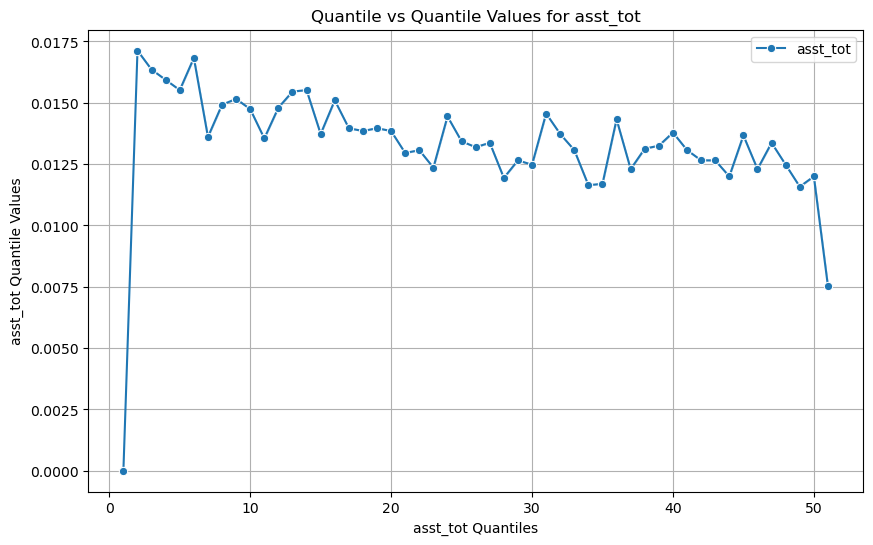

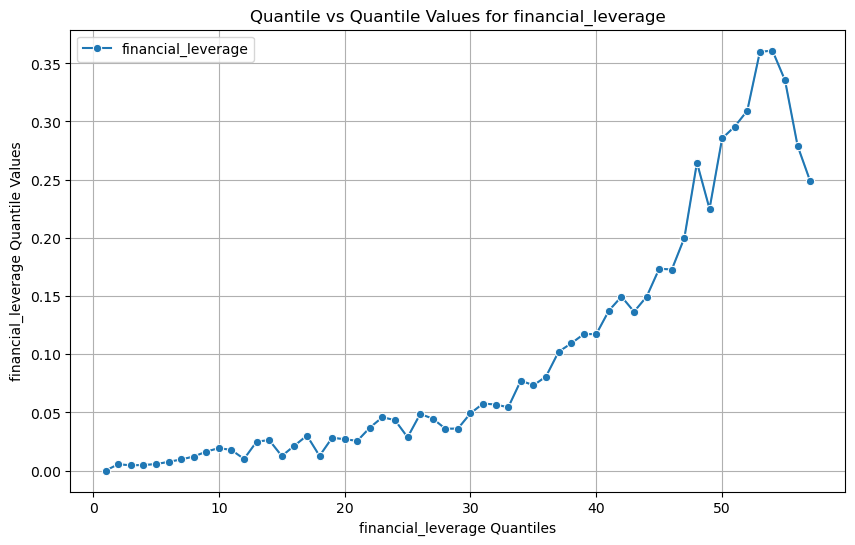

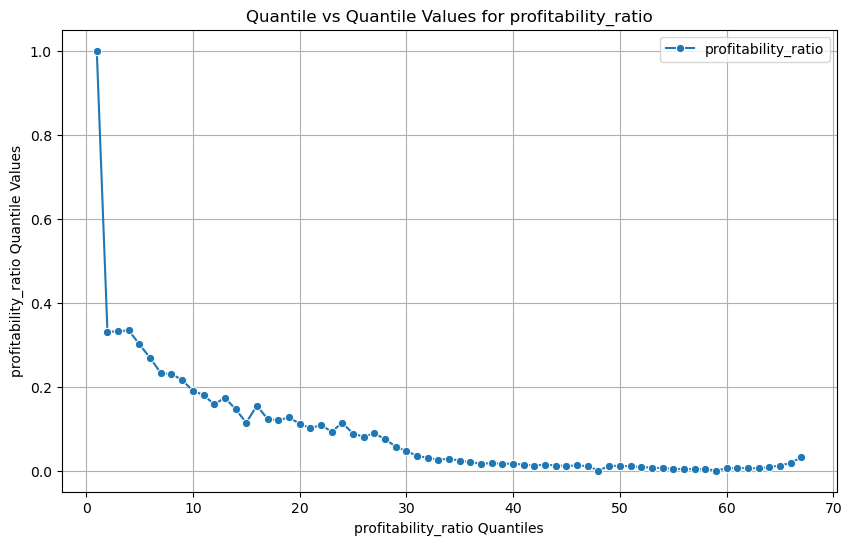

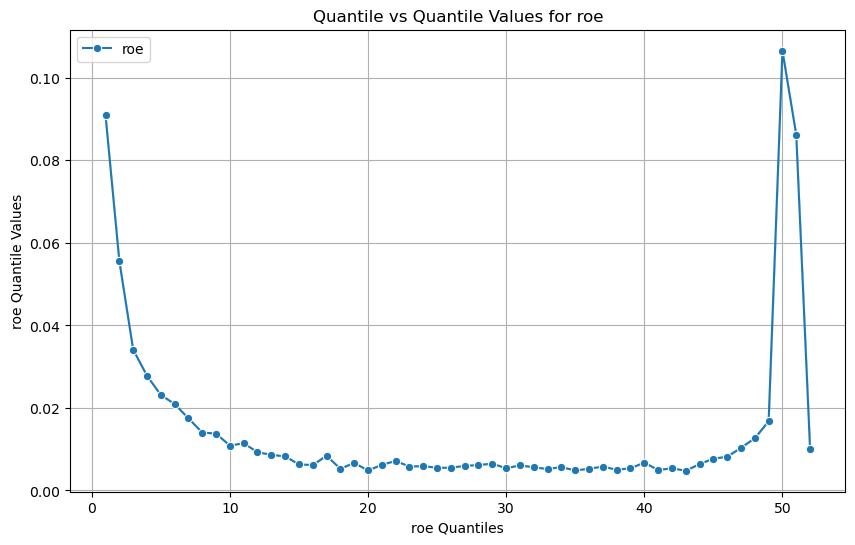

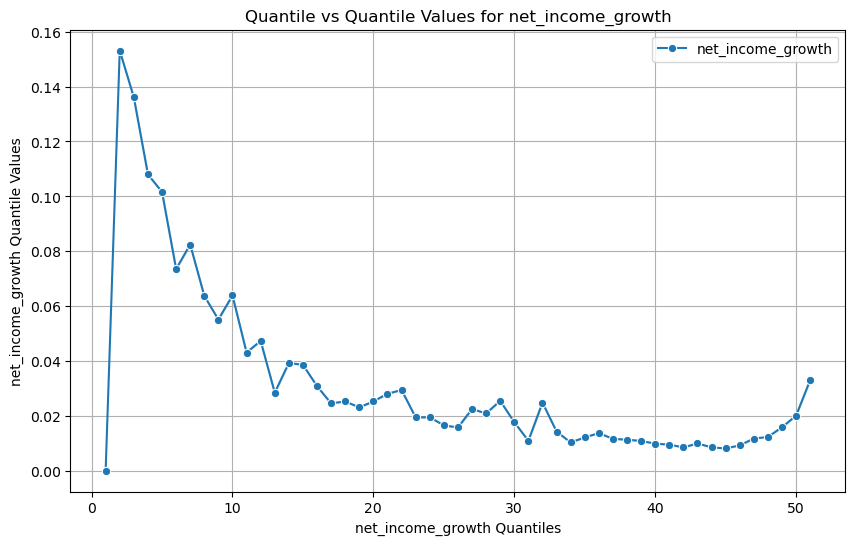

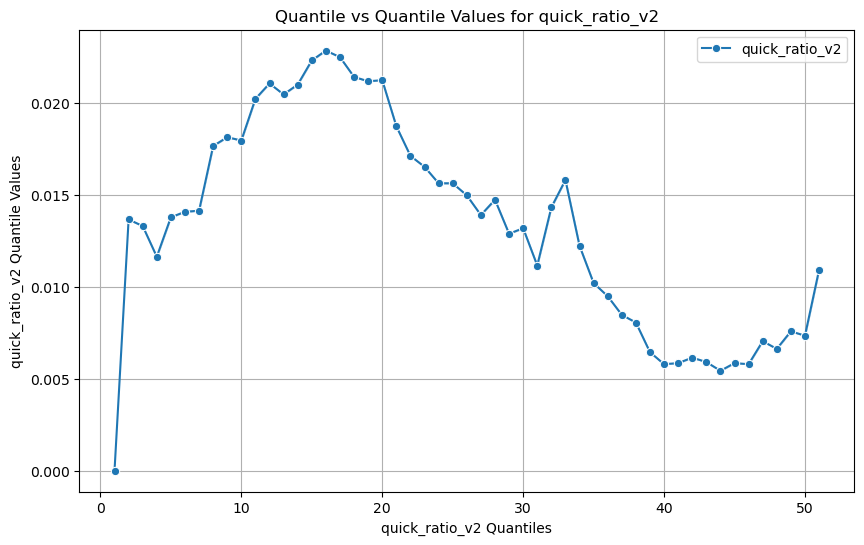

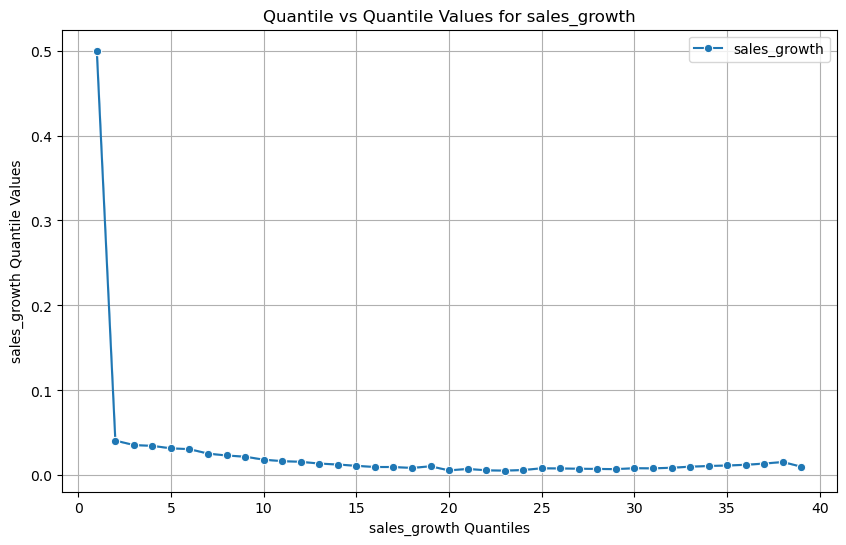

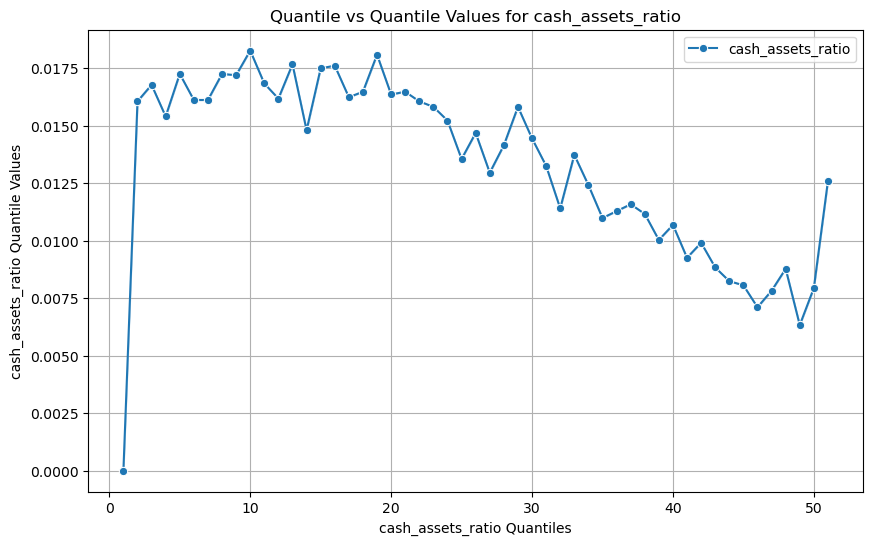

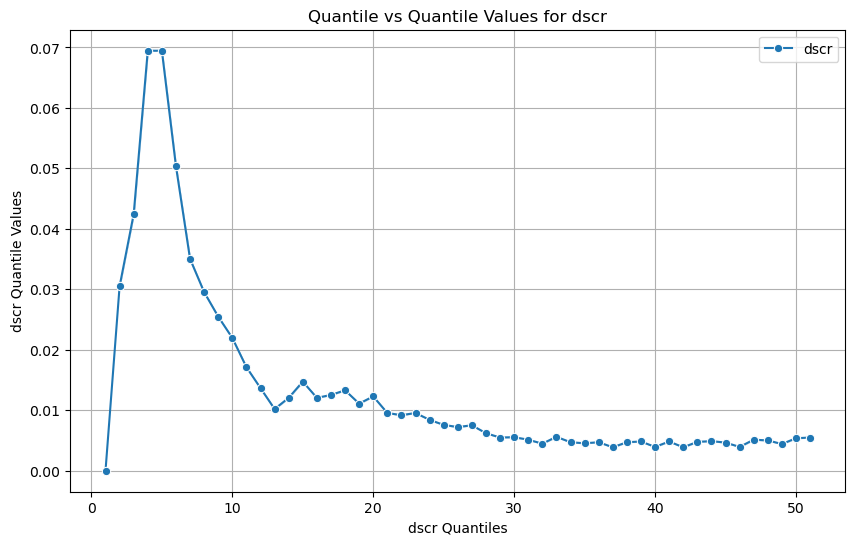

In [14]:
# Function to plot quantile vs quantile values for each feature
def plot_quantile_vs_quantile_values(df):
    """
    Plot quantile values for each feature if both the quantile and corresponding
    quantile values columns are available, based on column name pattern.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    """
    # Identify columns with the pattern '_quantile' and '_quantile_values'
    quantile_columns = [col for col in df.columns if col.endswith('_quantile')]
    quantile_values_columns = [col for col in df.columns if col.endswith('_quantile_values')]

    # Loop over each quantile column and check if the corresponding quantile values column exists
    for quantile_col in quantile_columns:
        feature_name = quantile_col.replace('_quantile', '')
        quantile_values_col = f"{feature_name}_quantile_values"

        # Plot if both columns exist
        if quantile_col in df.columns and quantile_values_col in df.columns:
            plt.figure(figsize=(10, 6))
            sns.lineplot(x=df[quantile_col], y=df[quantile_values_col], marker='o', label=f'{feature_name}')
            plt.title(f'Quantile vs Quantile Values for {feature_name}')
            plt.xlabel(f'{feature_name} Quantiles')
            plt.ylabel(f'{feature_name} Quantile Values')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print(f"Could not find both columns for feature '{feature_name}'.")


plot_quantile_vs_quantile_values(test_processed)